<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter07/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a default CNN model on MNIST dataset to benchmark it's accuracy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [3]:
def train(train_dataloader, val_dataloader, model=None, epochs=1, early_stopping=False):
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    train_losses = []
    val_losses = []
    val_accuracies = []
    model.train()
    best_val_acc = 0.0
    patience = 0
    optimal_model = copy.deepcopy(model)
    for epoch in range(epochs):
        train_epoch_loss = 0.0
        n_total = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = F.nll_loss(pred_prob, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.cpu().item() * len(y)
            n_total += len(y)
        train_epoch_loss = train_epoch_loss / n_total
        train_losses.append(train_epoch_loss)
        print("Epoch %d/%d train loss: %.4f" % (epoch + 1, epochs, train_epoch_loss))
        targets = []
        outputs = []
        success = 0
        n_total = 0
        with torch.no_grad():
            loss = 0.0
            val_epoch_loss = 0.0
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += (
                    F.nll_loss(pred_prob, y, reduction="sum")
                    .detach()
                    .cpu()
                    .numpy()
                    .item()
                )  # loss summed across the batch
                pred = pred_prob.argmax(
                    dim=1, keepdim=True
                )  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().detach().cpu().numpy()
                outputs.append(pred.view(-1))
                targets.append(y)
                n_total += len(y)
            accuracy = 100.0 * success / n_total
            if accuracy > best_val_acc:
                best_val_acc = accuracy
                optimal_model = copy.deepcopy(model)
                patience = 0
            else:
                patience += 1
            val_loss = loss / n_total
            val_accuracies.append(accuracy)
            val_losses.append(val_loss)
        print("Epoch %d/%d validation loss: %.4f" % (epoch + 1, epochs, val_loss))
        print("Epoch %d/%d validation accuracy: %.4f" % (epoch + 1, epochs, accuracy))
        if (early_stopping) and (patience > 2):
            print("Early stopping at epoch %d/%d" % (epoch + 1, epochs))
            break
    last_epoch = epoch
    return optimal_model, train_losses, val_losses, val_accuracies, last_epoch


def test(model):
    model.eval()
    loss = 0
    success = 0
    correct = 0
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    targets = []
    outputs = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += (
                F.nll_loss(pred_prob, y, reduction="sum").detach().cpu().numpy()
            )  # loss summed across the batch
            pred = pred_prob.argmax(
                dim=1, keepdim=True
            )  # use argmax to get the most likely prediction
            correct = np.squeeze(pred.eq(y.view_as(pred)))
            success += pred.eq(y.view_as(pred)).sum().item()
            outputs.append(pred.view(-1))
            targets.append(y)

    loss /= len(test_dataloader.dataset)

    accuracy = 100.0 * success / len(test_dataloader.dataset)

    print(
        "\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(
            loss, success, len(test_dataloader.dataset), accuracy
        )
    )

    for i in range(len(y)):
        label = y[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    class_percentages = []
    for i in range(len(class_correct)):
        class_percentages.append(class_correct[i] / class_total[i])

    return accuracy, class_percentages

## Orignal Mnist Dataset Class distribution

100%|██████████| 9912422/9912422 [00:00<00:00, 125210320.36it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106166252.26it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35294163.80it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25883870.61it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Distribution of classes in original train dataset:


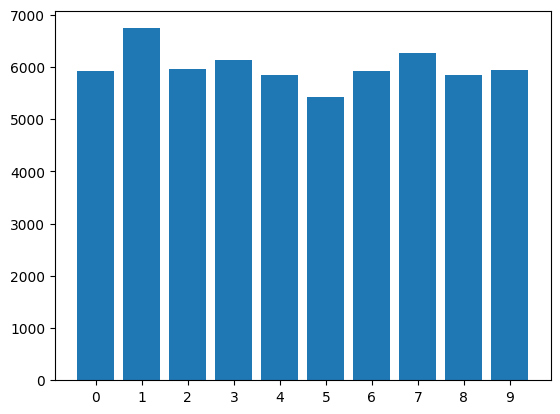

In [4]:
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)
m = len(trainset)

train_data, val_data = random_split(
    trainset,
    [int(m - m * 0.2), m - int(m - m * 0.2)],
    generator=torch.Generator().manual_seed(seed),
)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

print(Counter(trainset.targets.numpy()))

print("Distribution of classes in original train dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [5]:
test_ds = datasets.MNIST(
    "../data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500)

# Balanced/Orignal Dataset Training

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
epochs = 10
optimal_model, train_losses, val_losses, val_accuracies, last_epoch = train(
    train_dataloader, val_dataloader, ConvNet().to(device), epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10 train loss: 0.4969
Epoch 1/10 validation loss: 0.2350
Epoch 1/10 validation accuracy: 93.0917
Epoch 2/10 train loss: 0.1764
Epoch 2/10 validation loss: 0.1466
Epoch 2/10 validation accuracy: 95.8083
Epoch 3/10 train loss: 0.1204
Epoch 3/10 validation loss: 0.1164
Epoch 3/10 validation accuracy: 96.6167
Epoch 4/10 train loss: 0.0949
Epoch 4/10 validation loss: 0.0956
Epoch 4/10 validation accuracy: 97.2833
Epoch 5/10 train loss: 0.0810
Epoch 5/10 validation loss: 0.0887
Epoch 5/10 validation accuracy: 97.4167
Epoch 6/10 train loss: 0.0702
Epoch 6/10 validation loss: 0.0802
Epoch 6/10 validation accuracy: 97.6667
Epoch 7/10 train loss: 0.0645
Epoch 7/10 validation loss: 0.0719
Epoch 7/10 validation accuracy: 97.9417
Epoch 8/10 train loss: 0.0584
Epoch 8/10 validation loss: 0.0803
Epoch 8/10 validation accuracy: 97.5833
Epoch 9/10 train loss: 0.0528
Epoch 9/10 validation loss: 0.0691
Epoch 9/10 validation accuracy: 97.9250
Epoch 10/10 train loss: 0.0493
Epoch 10/10 validation l

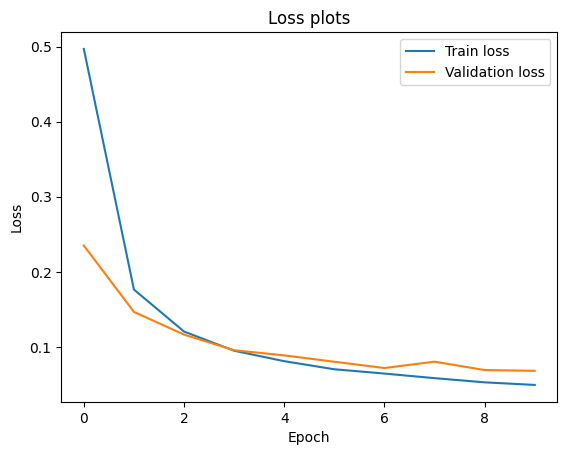

In [8]:
plt.plot(np.array(range(last_epoch + 1)), train_losses, label="Train loss")
plt.plot(np.array(range(last_epoch + 1)), val_losses, label="Validation loss")
plt.title("Loss plots")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

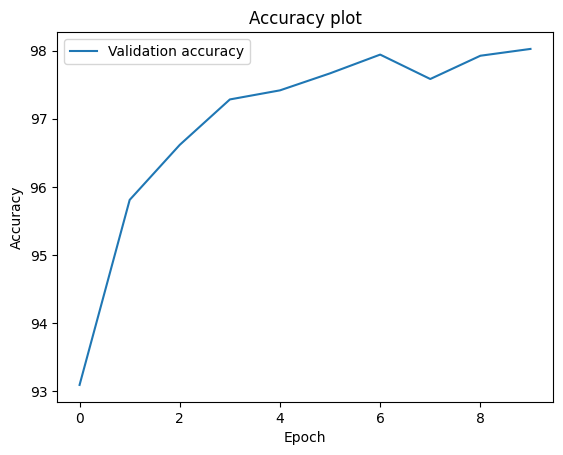

In [9]:
plt.plot(np.array(range(last_epoch + 1)), val_accuracies, label="Validation accuracy")
plt.title("Accuracy plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test Model

In [10]:
print("On vanilla MNIST dataset")
test_acc, percentages0 = test(optimal_model)
print("test accuracy : ", str(test_acc))

On vanilla MNIST dataset

Test dataset: Overall Loss: 0.0360, Overall Accuracy: 9883/10000 (99%)

test accuracy :  98.83


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


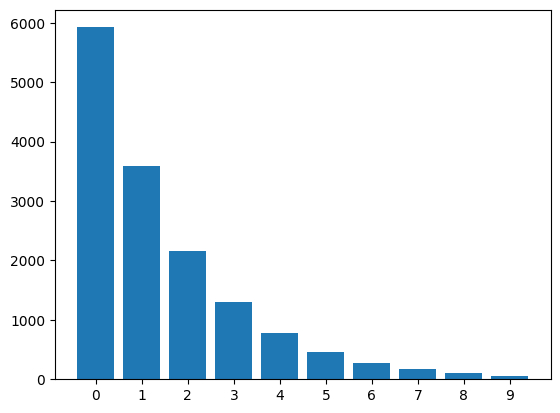

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
    ),
)

# generate imbalanced dataset
num_classes = 10
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

m = len(imbalanced_train_dataset)

imbalanced_train_data, imbalanced_val_data = random_split(
    imbalanced_train_dataset,
    [int(m - m * 0.2), m - int(m - m * 0.2)],
    generator=torch.Generator().manual_seed(42),
)

imbalanced_train_dataloader = torch.utils.data.DataLoader(
    imbalanced_train_data, batch_size=128, shuffle=True
)
imbalanced_val_dataloader = torch.utils.data.DataLoader(
    imbalanced_val_data, batch_size=128, shuffle=True
)

### train model on imbalanced dataset

In [12]:
epochs = 50
(
    imb_optimal_model,
    imb_train_losses,
    imb_val_losses,
    imb_val_accuracies,
    imb_last_epoch,
) = train(
    imbalanced_train_dataloader,
    imbalanced_val_dataloader,
    ConvNet().to(device),
    epochs=epochs,
)

Epoch 1/50 train loss: 0.5952
Epoch 1/50 validation loss: 0.3475
Epoch 1/50 validation accuracy: 90.1080
Epoch 2/50 train loss: 0.2407
Epoch 2/50 validation loss: 0.2547
Epoch 2/50 validation accuracy: 92.4038
Epoch 3/50 train loss: 0.1950
Epoch 3/50 validation loss: 0.2200
Epoch 3/50 validation accuracy: 93.7880
Epoch 4/50 train loss: 0.1642
Epoch 4/50 validation loss: 0.2005
Epoch 4/50 validation accuracy: 94.4294
Epoch 5/50 train loss: 0.1477
Epoch 5/50 validation loss: 0.1811
Epoch 5/50 validation accuracy: 94.5645
Epoch 6/50 train loss: 0.1302
Epoch 6/50 validation loss: 0.1591
Epoch 6/50 validation accuracy: 94.8683
Epoch 7/50 train loss: 0.1231
Epoch 7/50 validation loss: 0.1449
Epoch 7/50 validation accuracy: 95.5773
Epoch 8/50 train loss: 0.1103
Epoch 8/50 validation loss: 0.1462
Epoch 8/50 validation accuracy: 95.5773
Epoch 9/50 train loss: 0.1037
Epoch 9/50 validation loss: 0.1390
Epoch 9/50 validation accuracy: 95.9824
Epoch 10/50 train loss: 0.0952
Epoch 10/50 validation l

### test on test set

In [13]:
print("performance on MNIST testset")
imb_optimal_model_test_acc, percentages1 = test(imb_optimal_model)
print("test accuracy : ", str(imb_optimal_model_test_acc))

performance on MNIST testset

Test dataset: Overall Loss: 0.3362, Overall Accuracy: 9243/10000 (92%)

test accuracy :  92.43


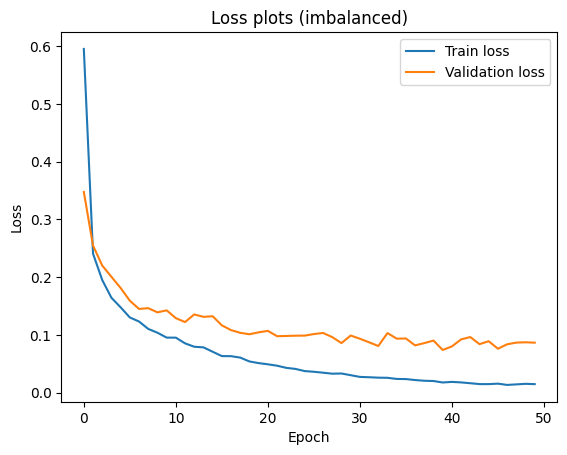

In [14]:
plt.plot(np.array(range(imb_last_epoch + 1)), imb_train_losses, label="Train loss")
plt.plot(np.array(range(imb_last_epoch + 1)), imb_val_losses, label="Validation loss")
plt.title("Loss plots (imbalanced)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

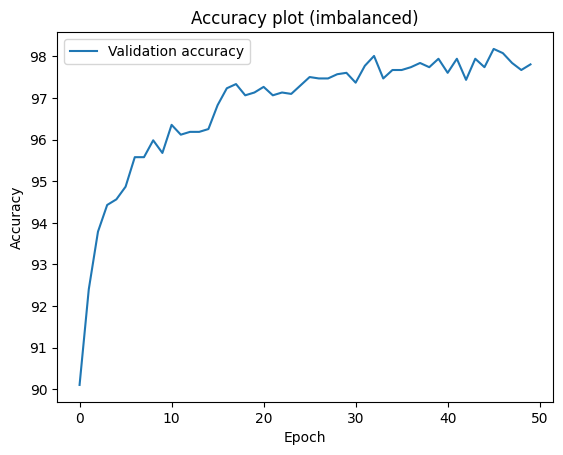

In [15]:
plt.plot(
    np.array(range(imb_last_epoch + 1)), imb_val_accuracies, label="Validation accuracy"
)
plt.title("Accuracy plot (imbalanced)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Balance the above create imbalanced dataset using VAE
Example references:
1. https://github.com/alexmanuele/Creating-Synthetic-Data-with-VAE/blob/master/using_VAE_to_improve_classification_performance.ipynb

2. https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

3. you can use your own references too

# Loading Mnist data

# Model definition

In [16]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3 * 3 * 32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc  # .cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale  # .cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu.to(device) + sigma * self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1 / 2).sum()
        return z

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [18]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims).to(device)
        self.decoder = Decoder(latent_dims).to(device)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [19]:
d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
print(f"Selected device: {device}")

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

# Training and Testing functions

In [20]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_ds.targets.numpy()
    t_idx = {
        i: np.where(targets == i)[0][np.random.randint(500, size=1)[0]]
        for i in range(n)
    }
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_ds[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n - 1:
            ax.set_title("Reconstructed images")
            plt.show()

In [21]:
def train_VAE(
    train_dataloader, val_dataloader, model=None, epochs=1, early_stopping=False
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    val_losses = []
    val_accuracies = []
    model.train()
    best_val_loss = 9999999999999.0
    patience = 0
    optimal_model = copy.deepcopy(model)
    for epoch in range(epochs):
        train_epoch_loss = 0.0
        n_total = 0
        for b_i, (X, _) in enumerate(train_dataloader):
            X = X.to(device)
            model = model.to(device)
            x_hat = model(X)
            loss = ((X - x_hat) ** 2).sum() + model.encoder.kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.cpu().item()
            n_total += len(X)
        train_epoch_loss = train_epoch_loss / n_total
        train_losses.append(train_epoch_loss)
        print(
            "Epoch %d/%d VAE train loss: %.4f" % (epoch + 1, epochs, train_epoch_loss)
        )

        n_total = 0
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0.0
            for x, _ in val_dataloader:
                x = x.to(device)
                x_hat = model(x)
                loss = ((x - x_hat) ** 2).sum() + model.encoder.kl
                val_epoch_loss += loss.detach().cpu().numpy()
                n_total += len(X)
            val_epoch_loss = val_epoch_loss / n_total
            if val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                optimal_model = copy.deepcopy(model)
                patience = 0
            else:
                patience += 1
            val_losses.append(val_epoch_loss)
        print(
            "Epoch %d/%d VAE validation loss: %.4f"
            % (epoch + 1, epochs, val_epoch_loss)
        )
        if (early_stopping) and (patience > 2):
            print("Early stopping at epoch %d/%d" % (epoch + 1, epochs))
            break
        plot_ae_outputs(model.encoder, model.decoder, n=10)
    last_epoch = epoch
    return optimal_model, train_losses, val_losses, last_epoch

# Visualization Module

# Start Visual Auto Encoder Training

Epoch 1/50 VAE train loss: 866.0835
Epoch 1/50 VAE validation loss: 1302.0828


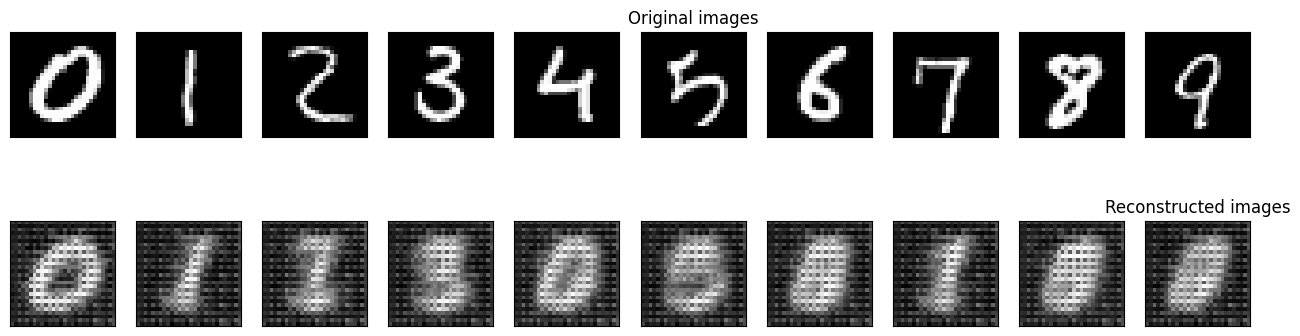

Epoch 2/50 VAE train loss: 549.2543
Epoch 2/50 VAE validation loss: 902.3581


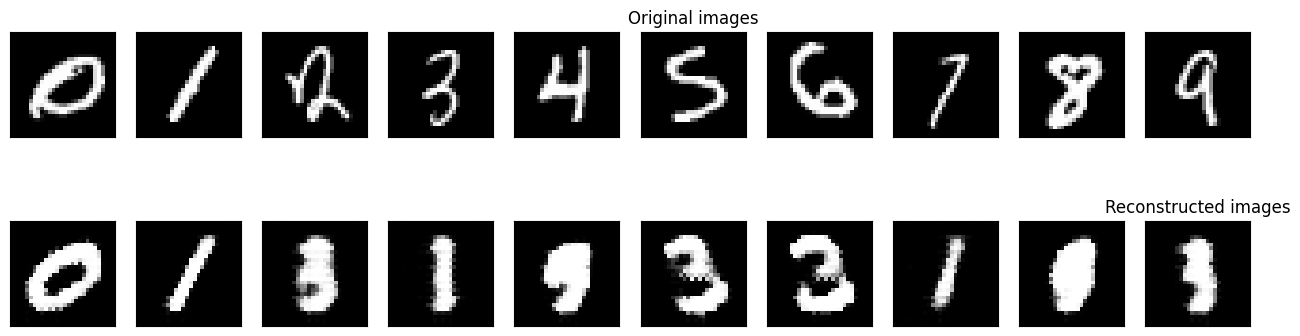

Epoch 3/50 VAE train loss: 509.3579
Epoch 3/50 VAE validation loss: 882.9185


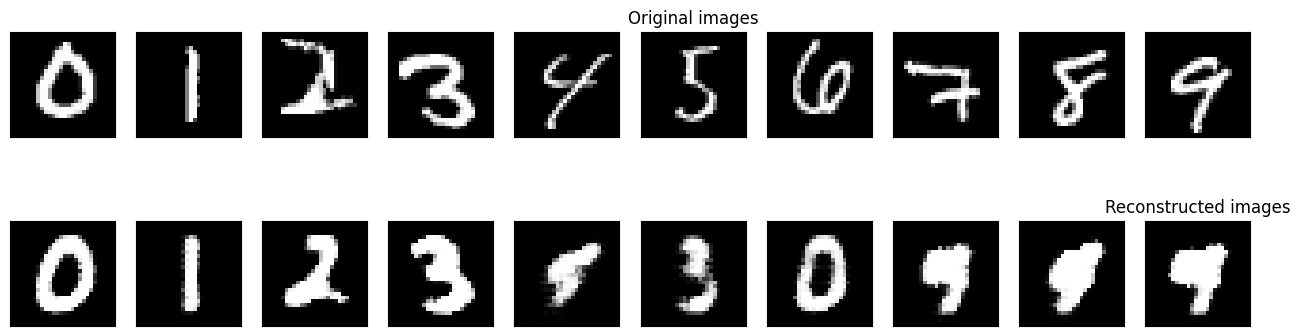

Epoch 4/50 VAE train loss: 501.9284
Epoch 4/50 VAE validation loss: 873.6623


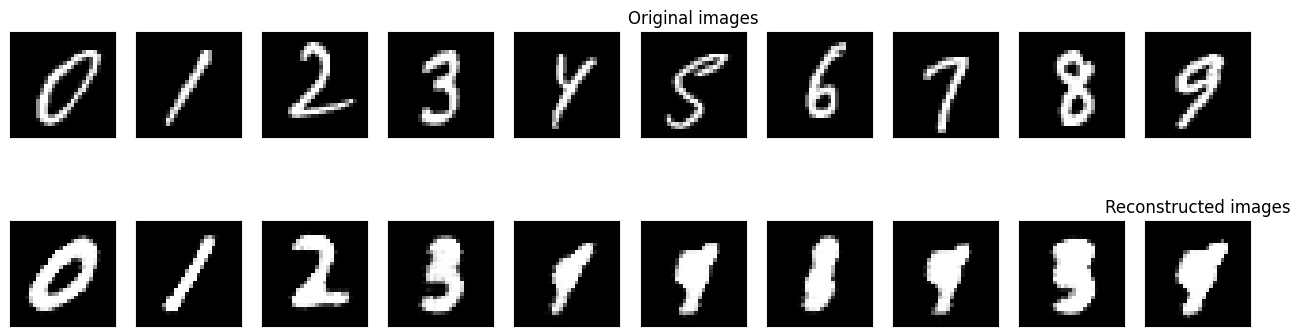

Epoch 5/50 VAE train loss: 497.0942
Epoch 5/50 VAE validation loss: 866.5174


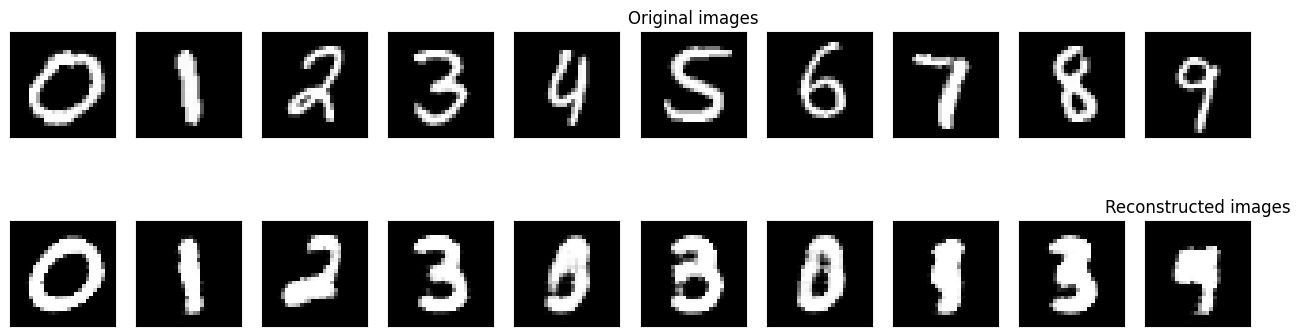

Epoch 6/50 VAE train loss: 493.5155
Epoch 6/50 VAE validation loss: 861.6771


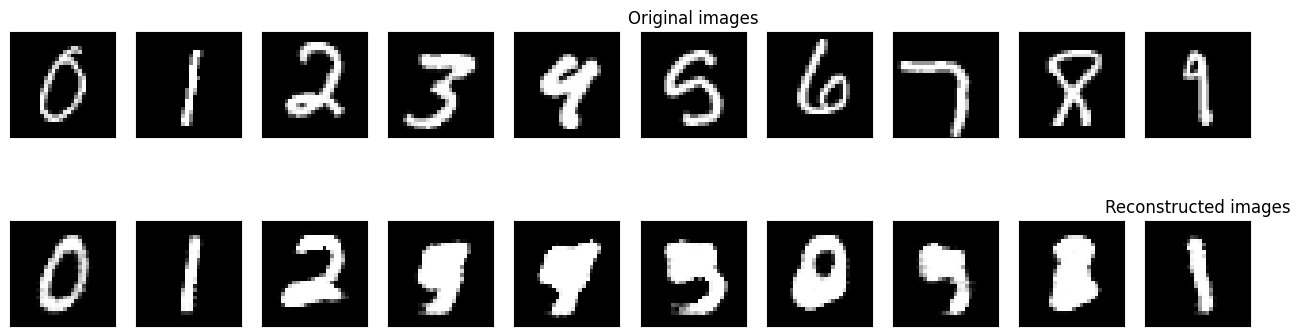

Epoch 7/50 VAE train loss: 491.0433
Epoch 7/50 VAE validation loss: 858.9821


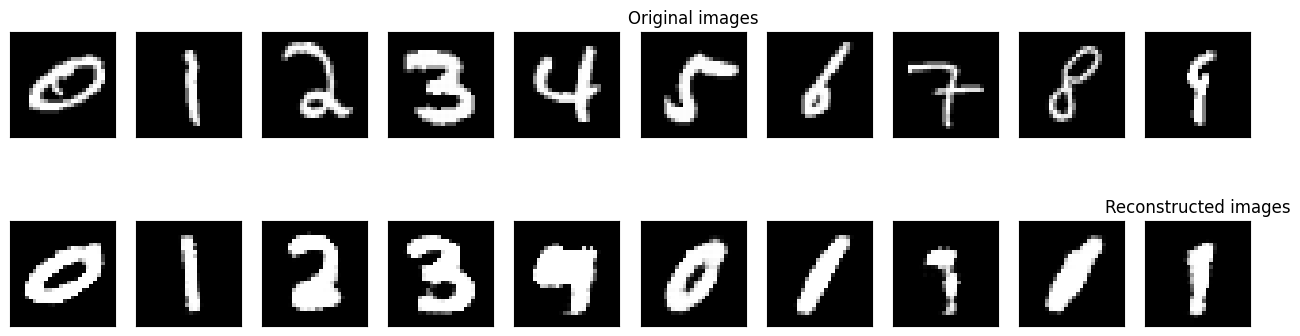

Epoch 8/50 VAE train loss: 489.3809
Epoch 8/50 VAE validation loss: 858.2034


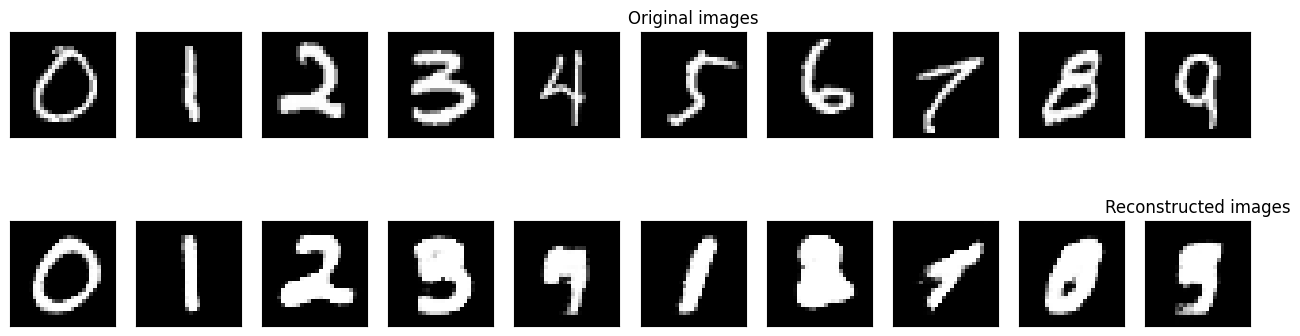

Epoch 9/50 VAE train loss: 487.7049
Epoch 9/50 VAE validation loss: 855.5739


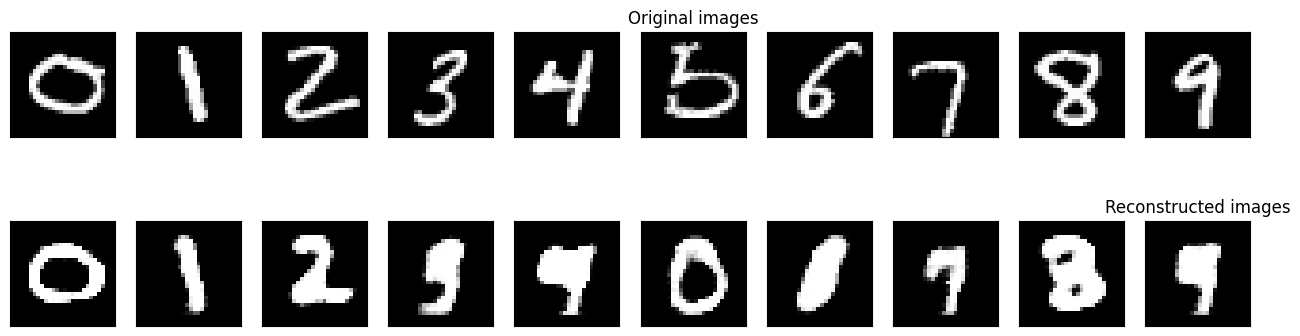

Epoch 10/50 VAE train loss: 486.2477
Epoch 10/50 VAE validation loss: 852.0182


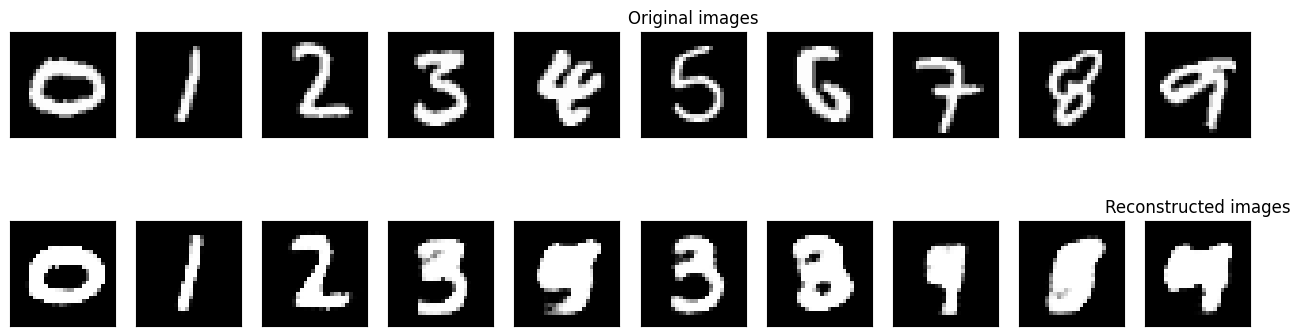

Epoch 11/50 VAE train loss: 485.2007
Epoch 11/50 VAE validation loss: 851.0673


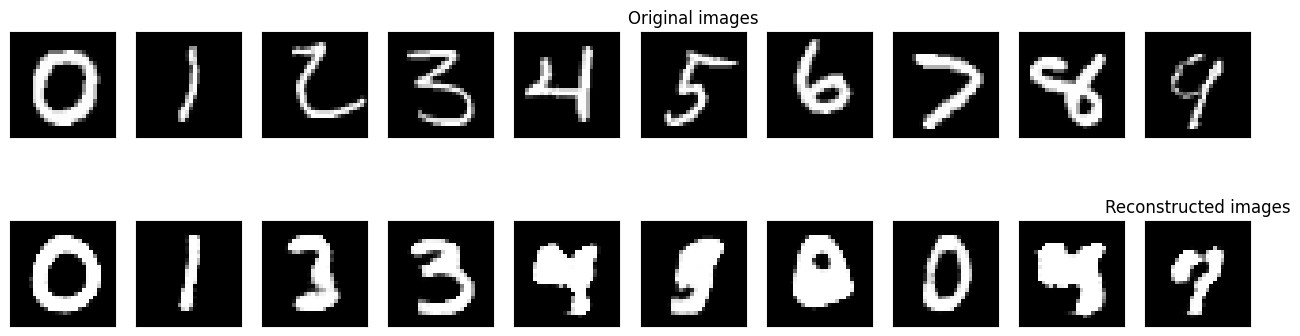

Epoch 12/50 VAE train loss: 483.7071
Epoch 12/50 VAE validation loss: 848.0550


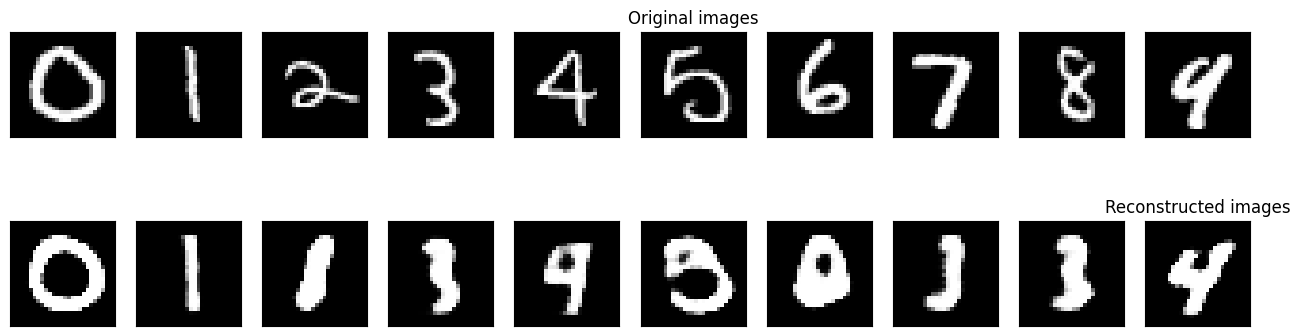

Epoch 13/50 VAE train loss: 482.8114
Epoch 13/50 VAE validation loss: 845.9128


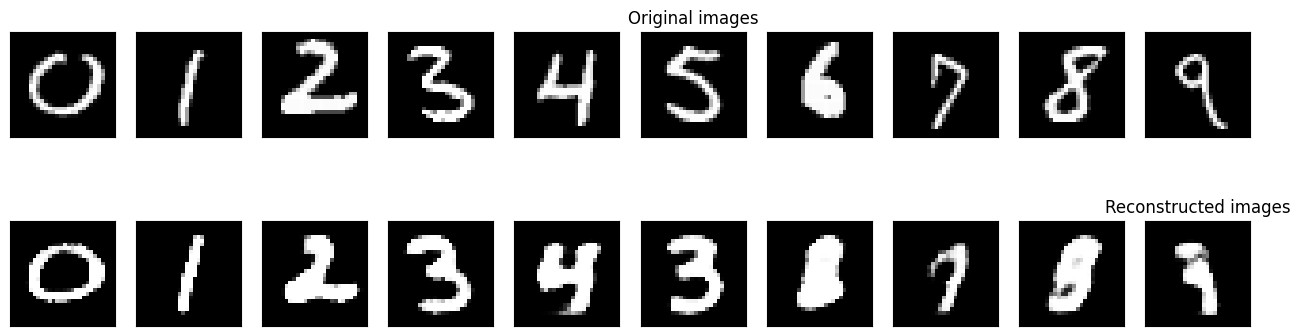

Epoch 14/50 VAE train loss: 481.5984
Epoch 14/50 VAE validation loss: 845.2600


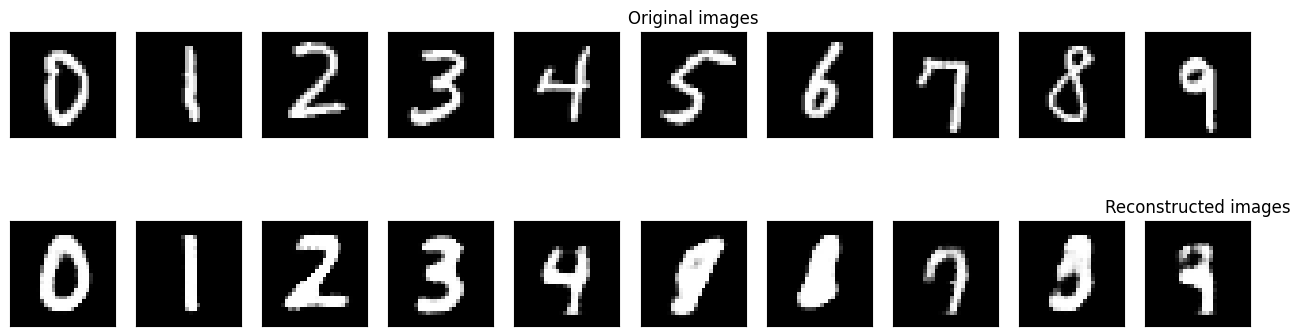

Epoch 15/50 VAE train loss: 481.0945
Epoch 15/50 VAE validation loss: 846.2453


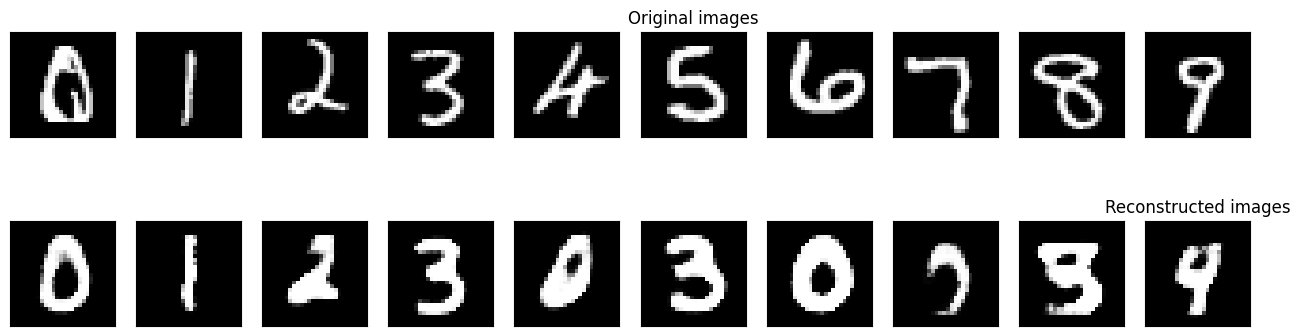

Epoch 16/50 VAE train loss: 480.0120
Epoch 16/50 VAE validation loss: 844.0367


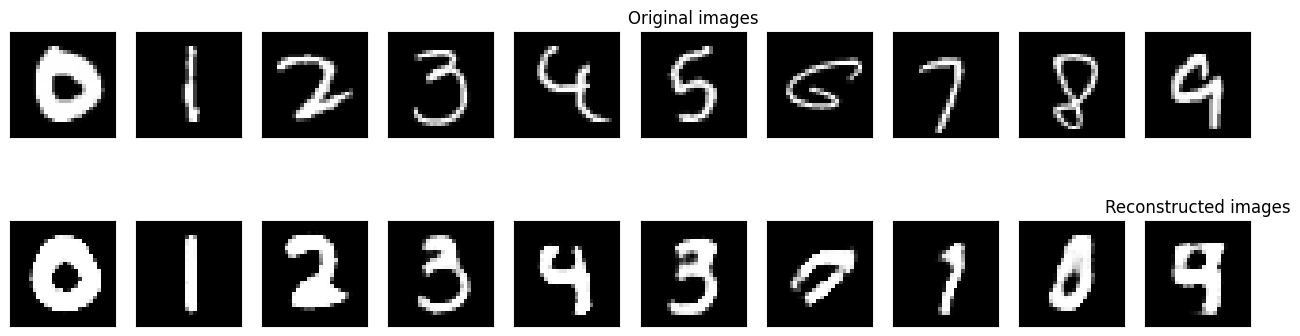

Epoch 17/50 VAE train loss: 479.5138
Epoch 17/50 VAE validation loss: 841.9416


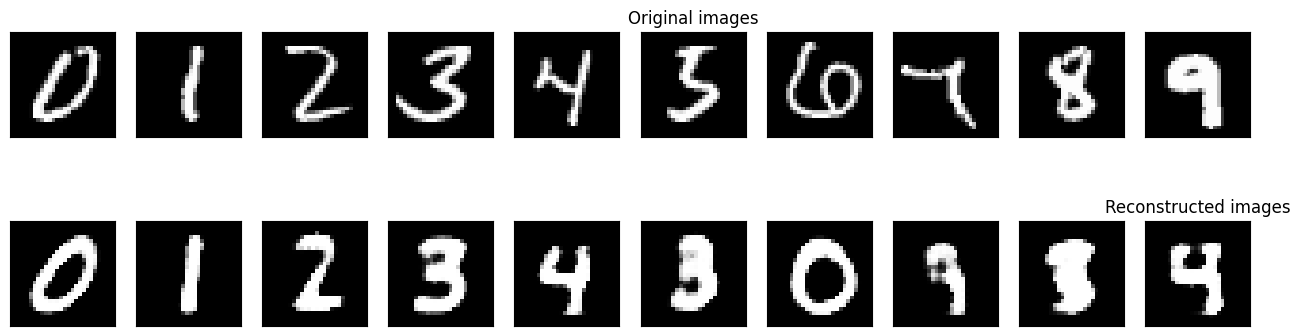

Epoch 18/50 VAE train loss: 478.8554
Epoch 18/50 VAE validation loss: 845.6992


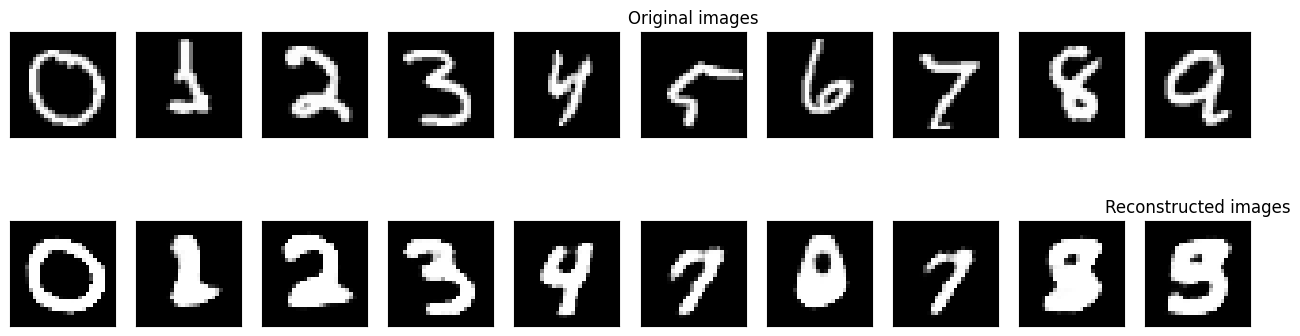

Epoch 19/50 VAE train loss: 478.3409
Epoch 19/50 VAE validation loss: 840.6176


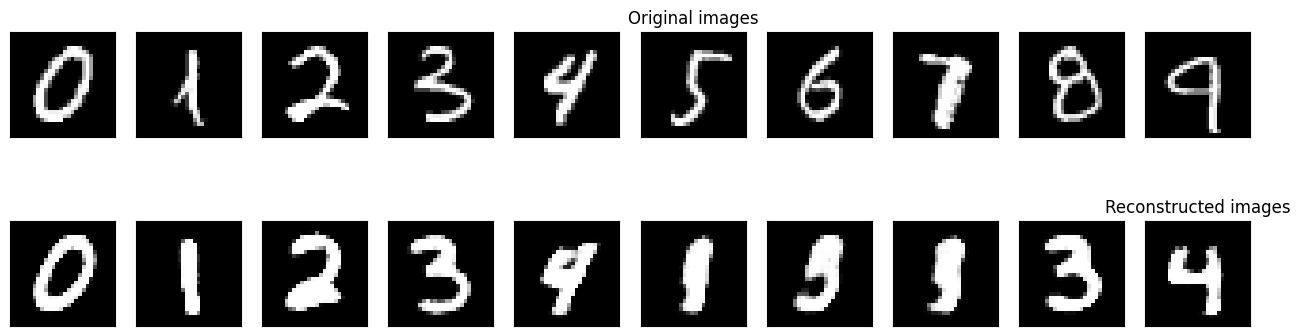

Epoch 20/50 VAE train loss: 477.7373
Epoch 20/50 VAE validation loss: 840.7113


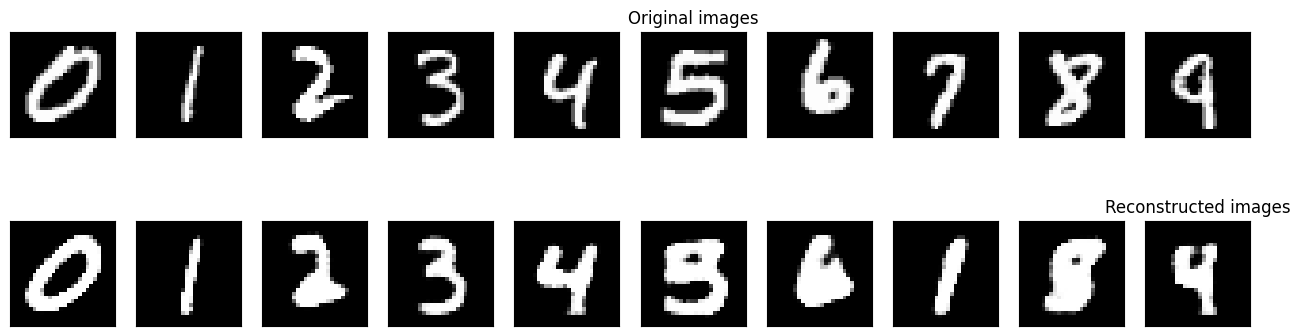

Epoch 21/50 VAE train loss: 477.3955
Epoch 21/50 VAE validation loss: 839.4976


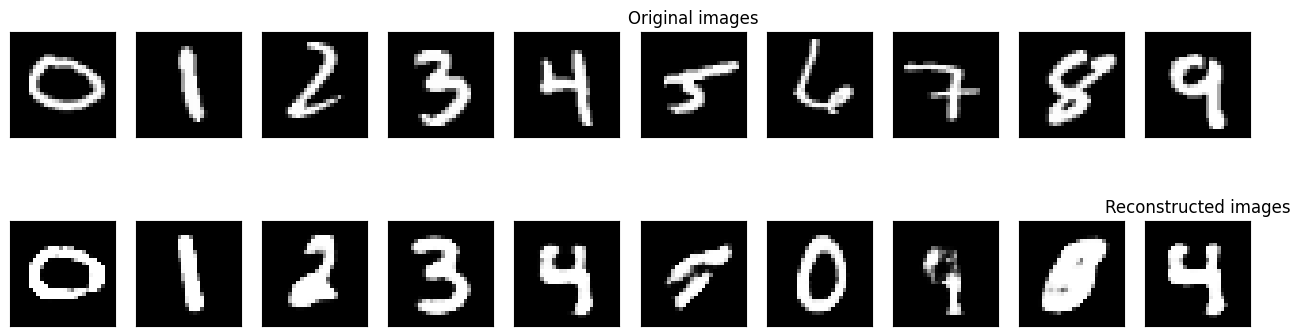

Epoch 22/50 VAE train loss: 476.8092
Epoch 22/50 VAE validation loss: 838.8854


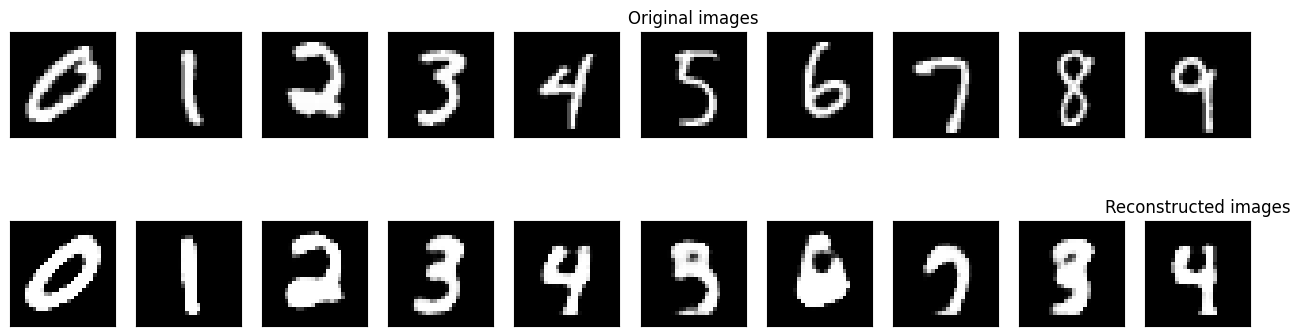

Epoch 23/50 VAE train loss: 476.6009
Epoch 23/50 VAE validation loss: 838.3805


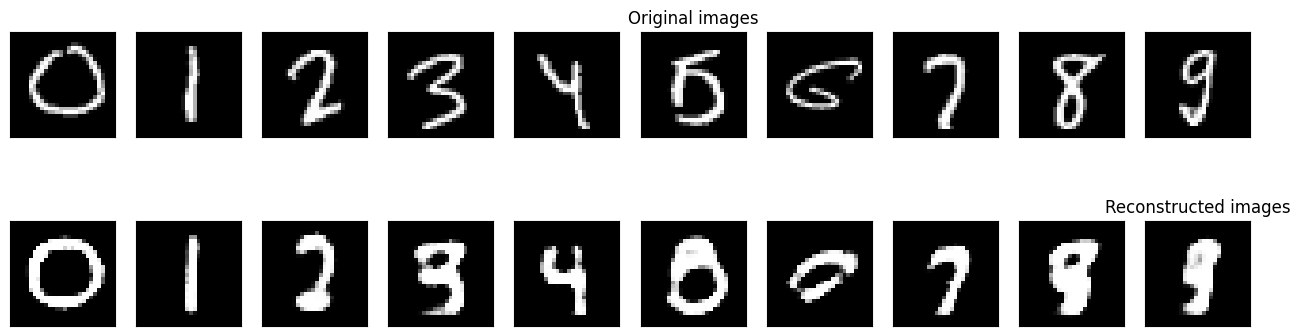

Epoch 24/50 VAE train loss: 476.0139
Epoch 24/50 VAE validation loss: 836.4153


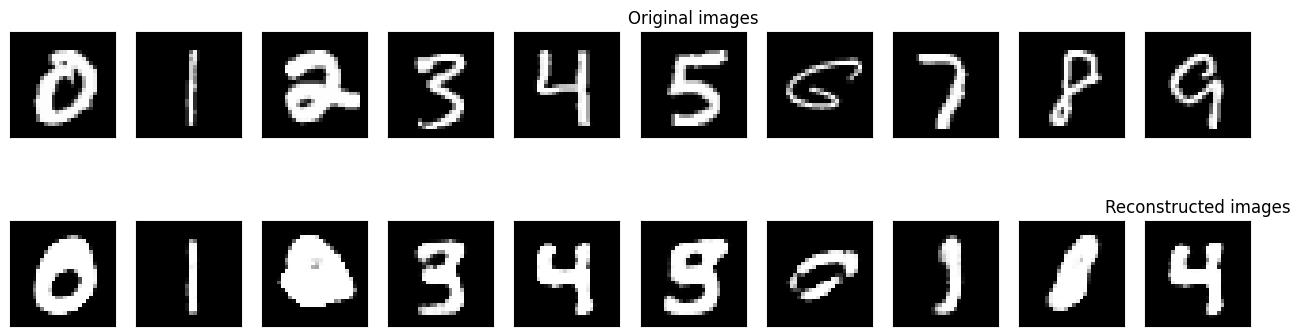

Epoch 25/50 VAE train loss: 475.4970
Epoch 25/50 VAE validation loss: 835.9441


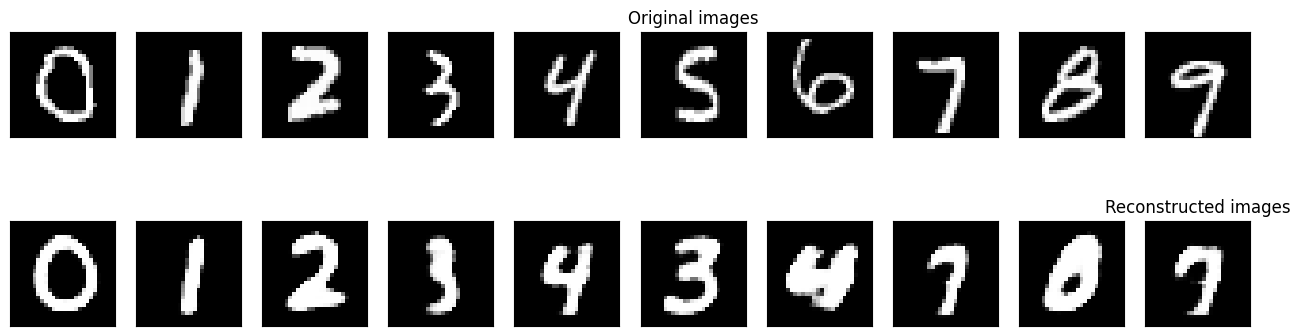

Epoch 26/50 VAE train loss: 475.1537
Epoch 26/50 VAE validation loss: 835.2302


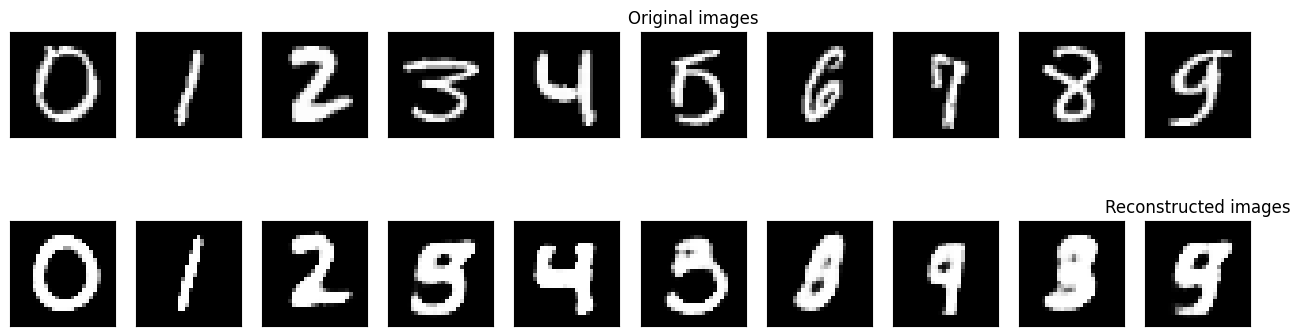

Epoch 27/50 VAE train loss: 474.8192
Epoch 27/50 VAE validation loss: 836.2788


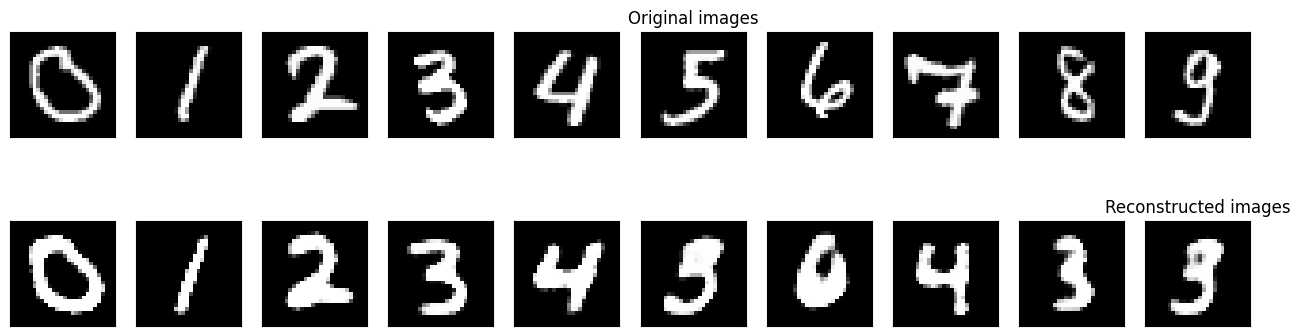

Epoch 28/50 VAE train loss: 474.2856
Epoch 28/50 VAE validation loss: 834.8095


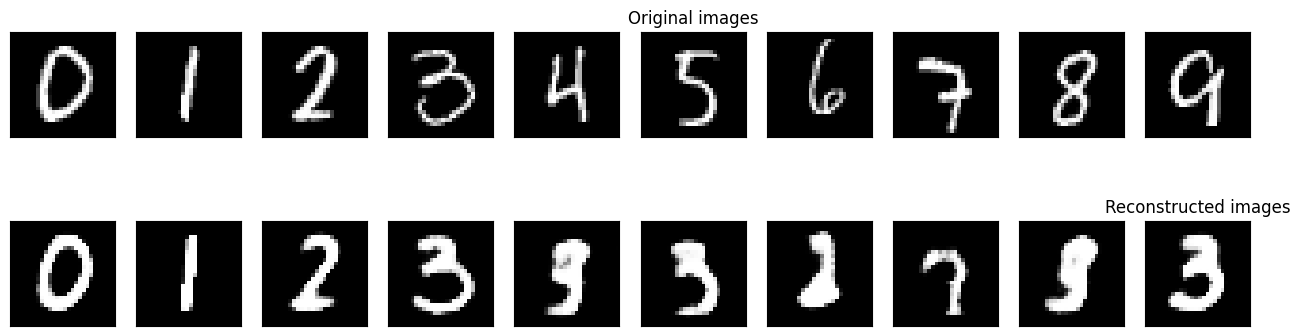

Epoch 29/50 VAE train loss: 474.0413
Epoch 29/50 VAE validation loss: 835.3949


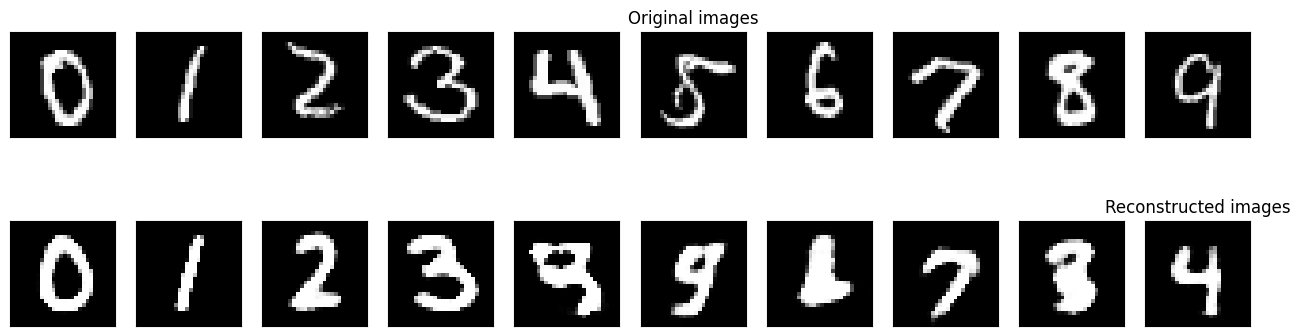

Epoch 30/50 VAE train loss: 473.6730
Epoch 30/50 VAE validation loss: 834.3719


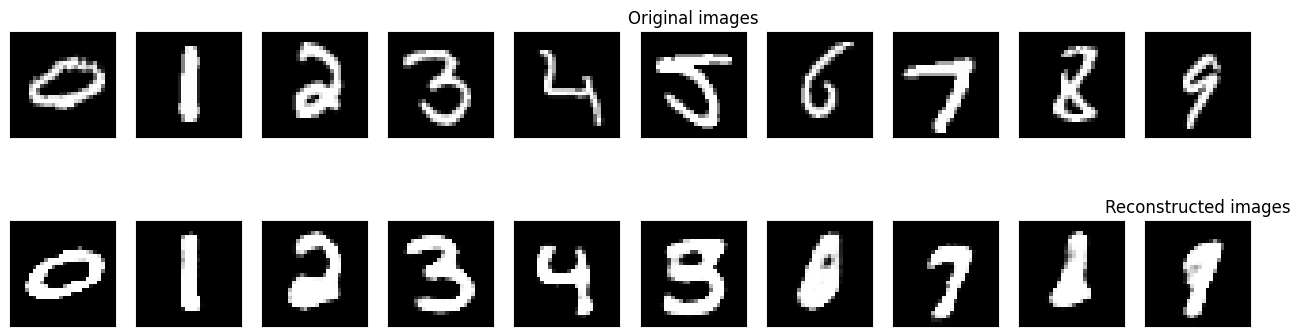

Epoch 31/50 VAE train loss: 473.4646
Epoch 31/50 VAE validation loss: 834.8429


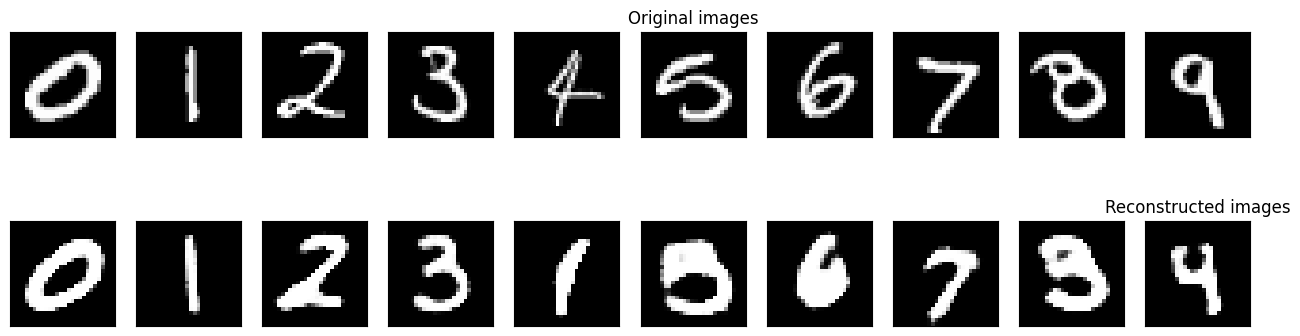

Epoch 32/50 VAE train loss: 473.0763
Epoch 32/50 VAE validation loss: 832.4906


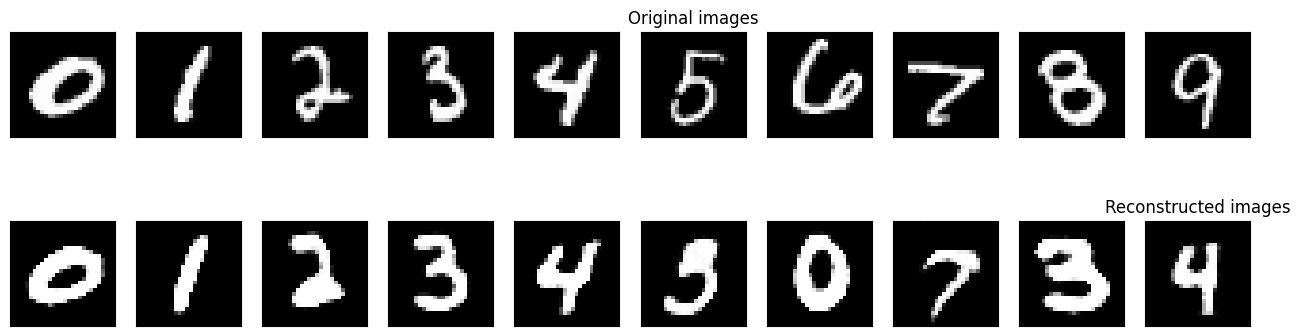

Epoch 33/50 VAE train loss: 472.8018
Epoch 33/50 VAE validation loss: 834.6031


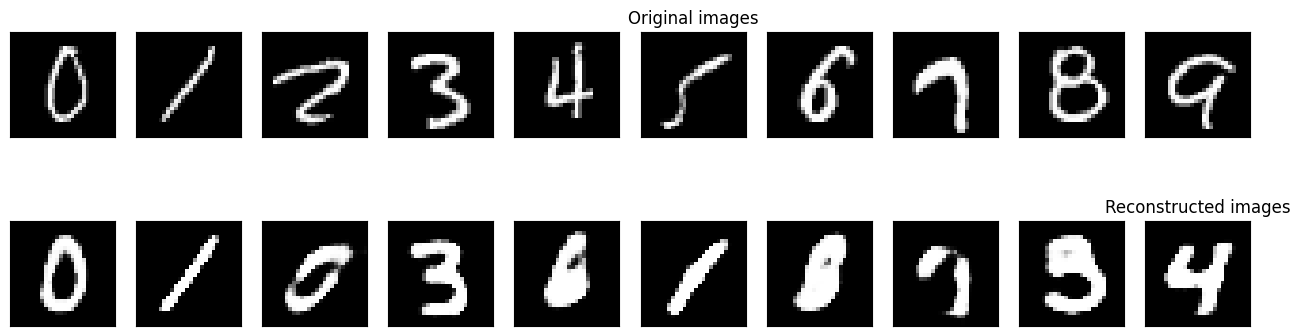

Epoch 34/50 VAE train loss: 472.7586
Epoch 34/50 VAE validation loss: 832.0329


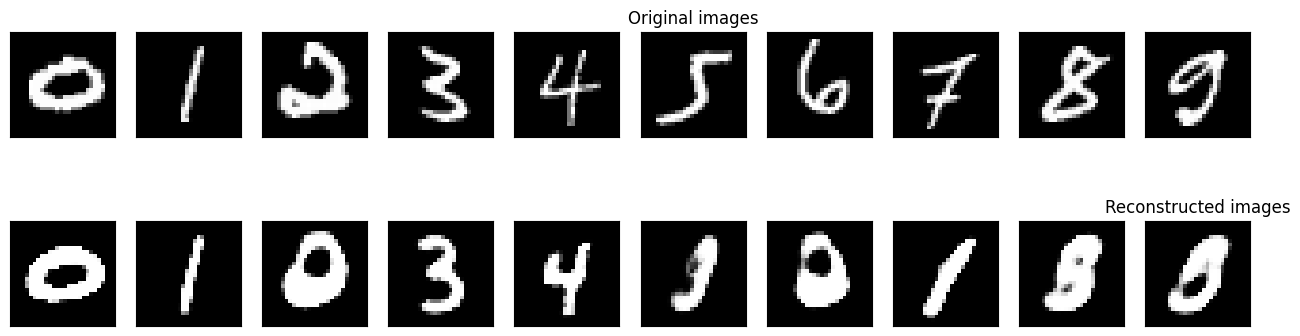

Epoch 35/50 VAE train loss: 472.2125
Epoch 35/50 VAE validation loss: 832.7353


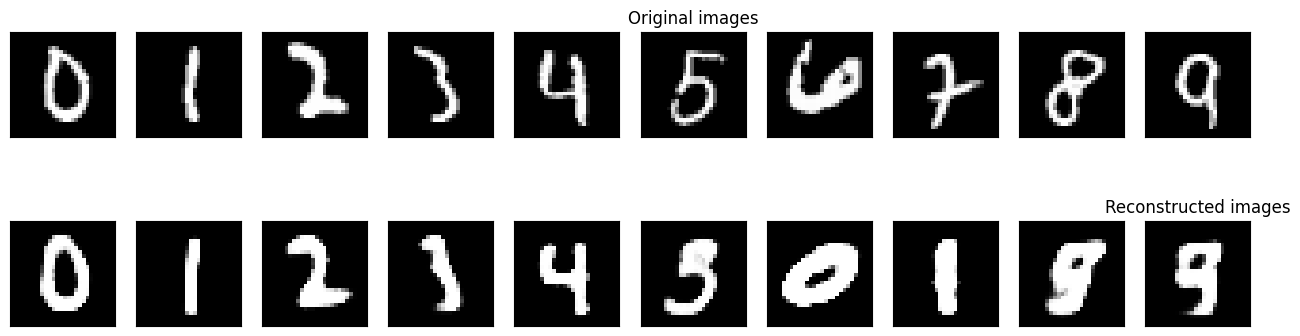

Epoch 36/50 VAE train loss: 472.1277
Epoch 36/50 VAE validation loss: 833.7002


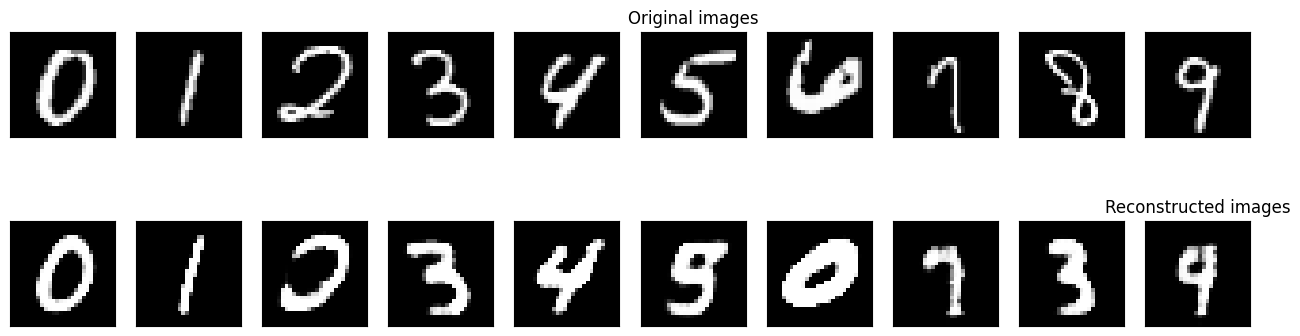

Epoch 37/50 VAE train loss: 471.9843
Epoch 37/50 VAE validation loss: 832.1663


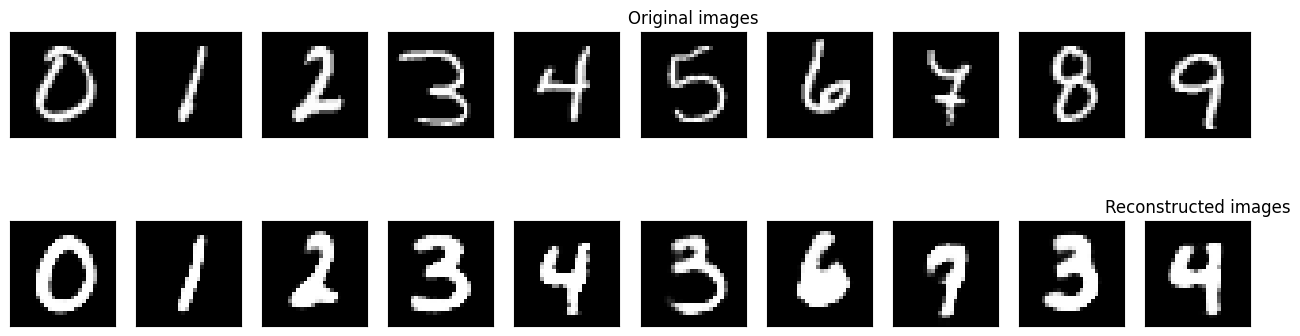

Epoch 38/50 VAE train loss: 471.6610
Epoch 38/50 VAE validation loss: 831.9870


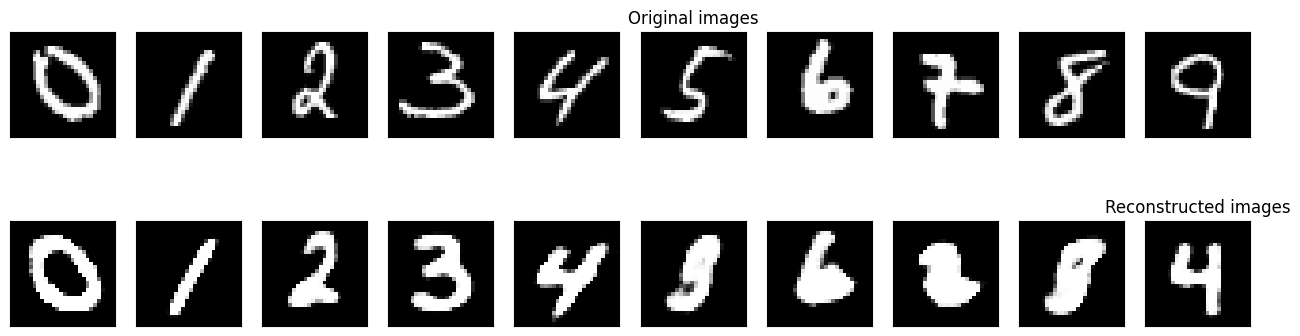

Epoch 39/50 VAE train loss: 471.4366
Epoch 39/50 VAE validation loss: 831.1669


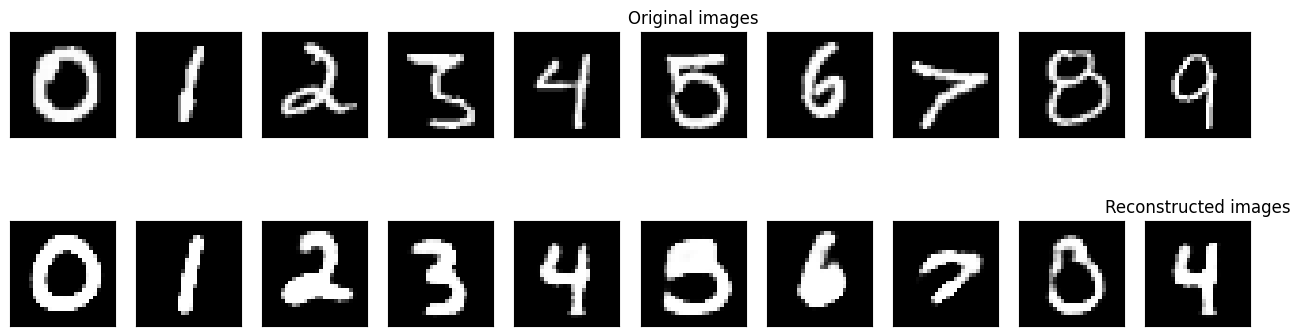

Epoch 40/50 VAE train loss: 471.2169
Epoch 40/50 VAE validation loss: 830.2445


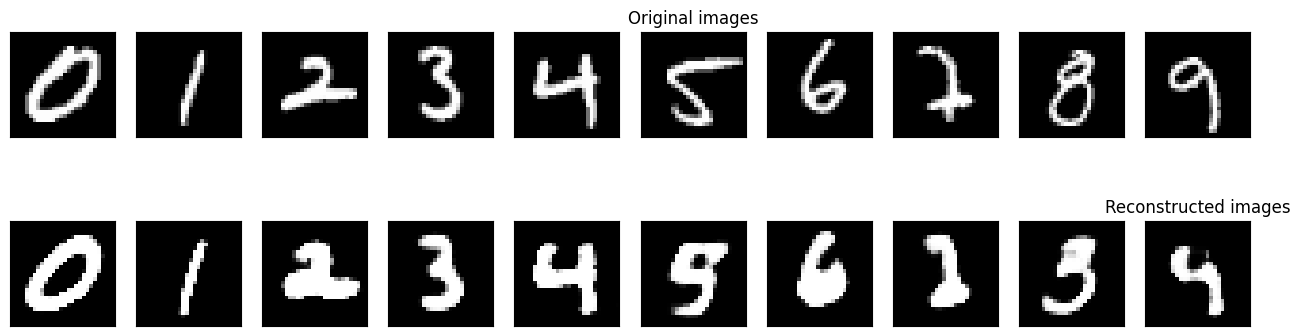

Epoch 41/50 VAE train loss: 470.9621
Epoch 41/50 VAE validation loss: 831.5752


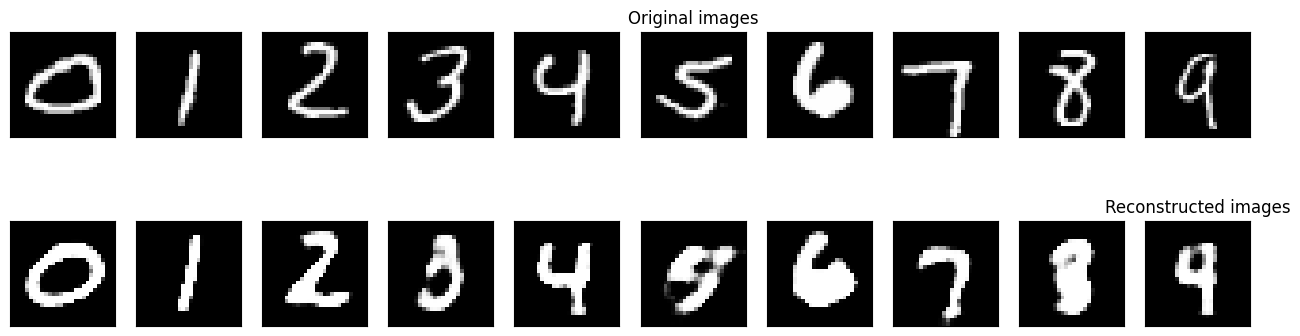

Epoch 42/50 VAE train loss: 470.9521
Epoch 42/50 VAE validation loss: 831.2096


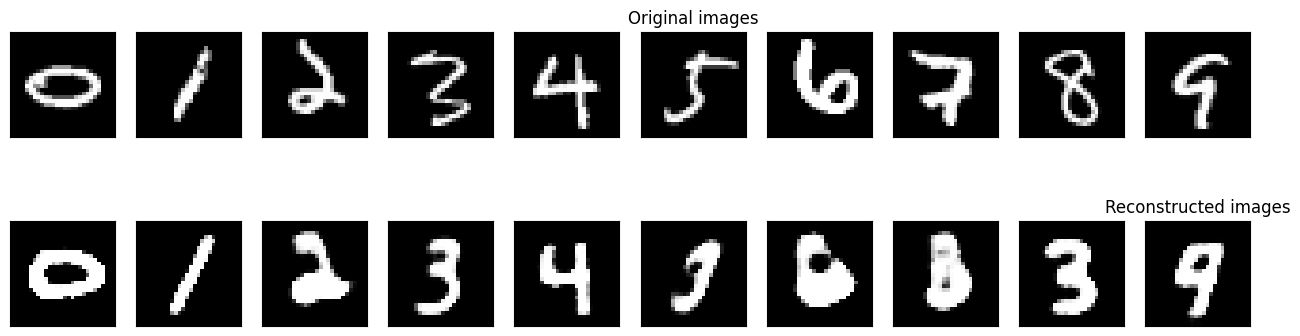

Epoch 43/50 VAE train loss: 470.4493
Epoch 43/50 VAE validation loss: 830.9821


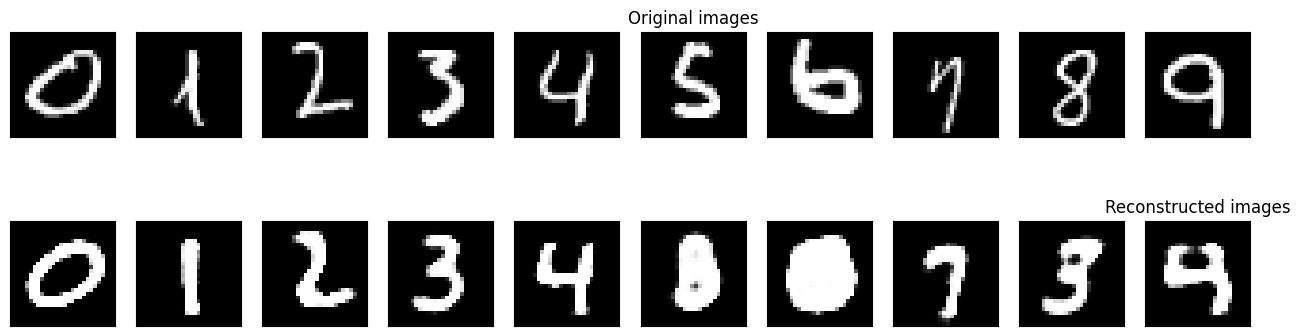

Epoch 44/50 VAE train loss: 470.4493
Epoch 44/50 VAE validation loss: 830.3357


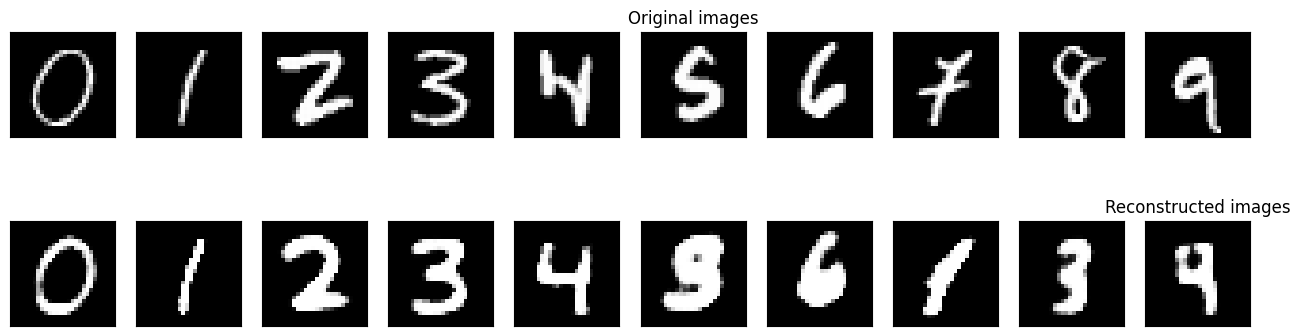

Epoch 45/50 VAE train loss: 470.3105
Epoch 45/50 VAE validation loss: 831.5977


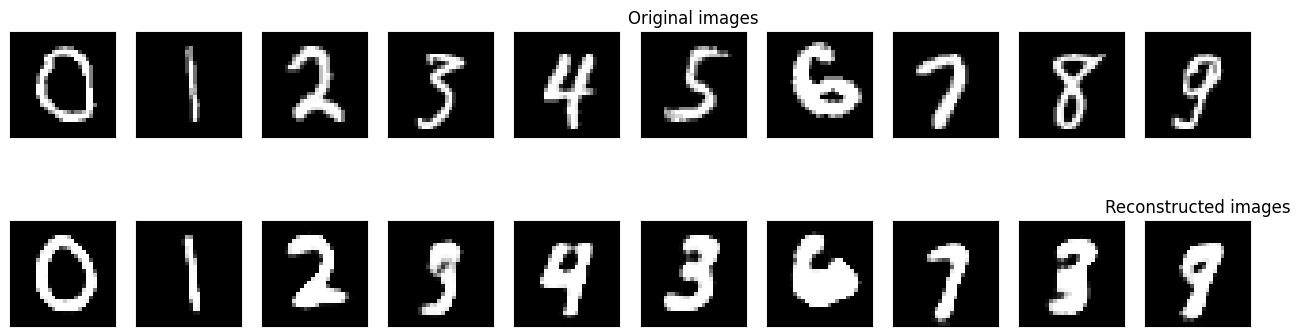

Epoch 46/50 VAE train loss: 470.0382
Epoch 46/50 VAE validation loss: 829.9021


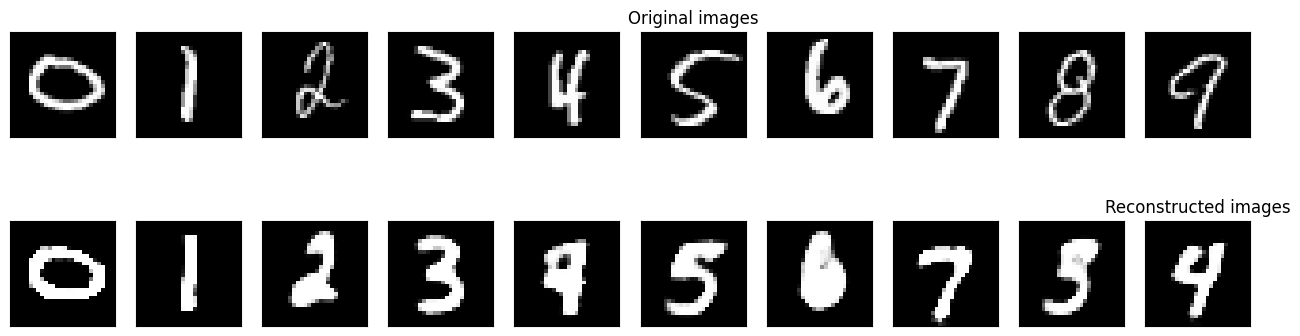

Epoch 47/50 VAE train loss: 469.9291
Epoch 47/50 VAE validation loss: 829.7453


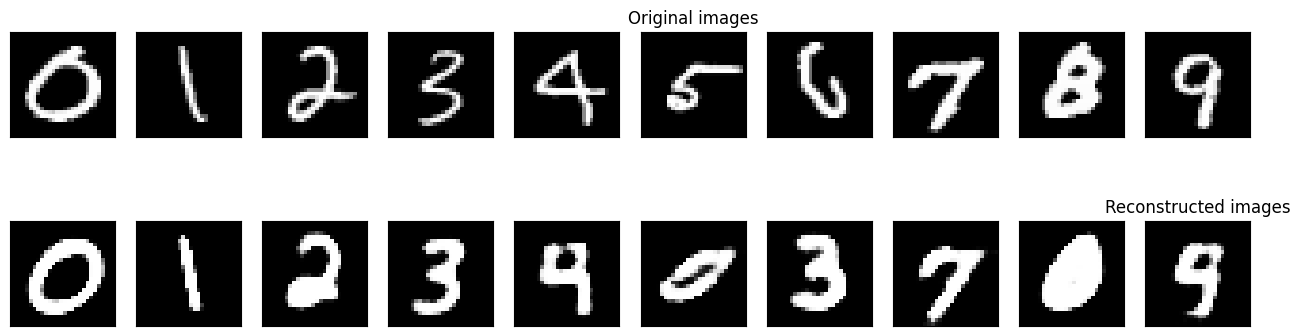

Epoch 48/50 VAE train loss: 469.6244
Epoch 48/50 VAE validation loss: 829.4684


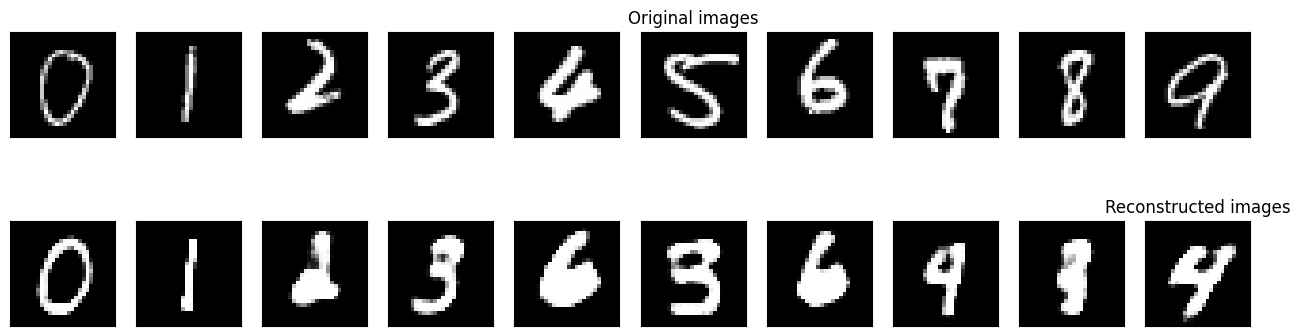

Epoch 49/50 VAE train loss: 469.6635
Epoch 49/50 VAE validation loss: 830.5380


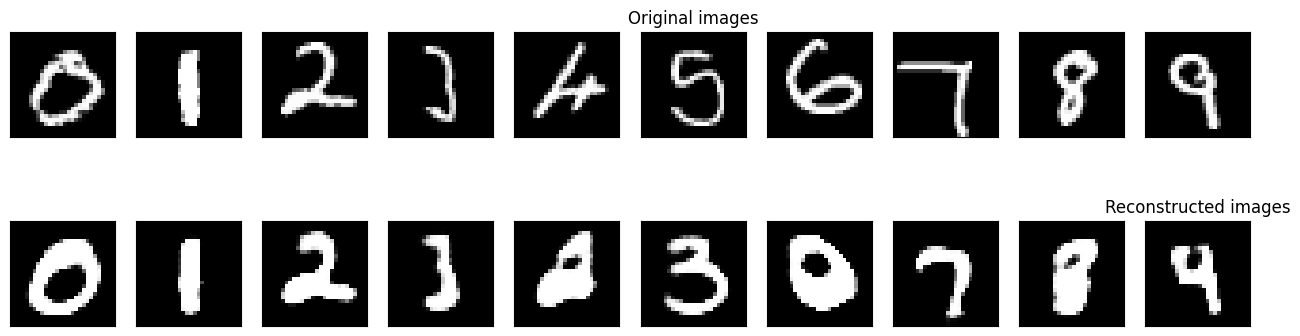

Epoch 50/50 VAE train loss: 469.5273
Epoch 50/50 VAE validation loss: 830.5092


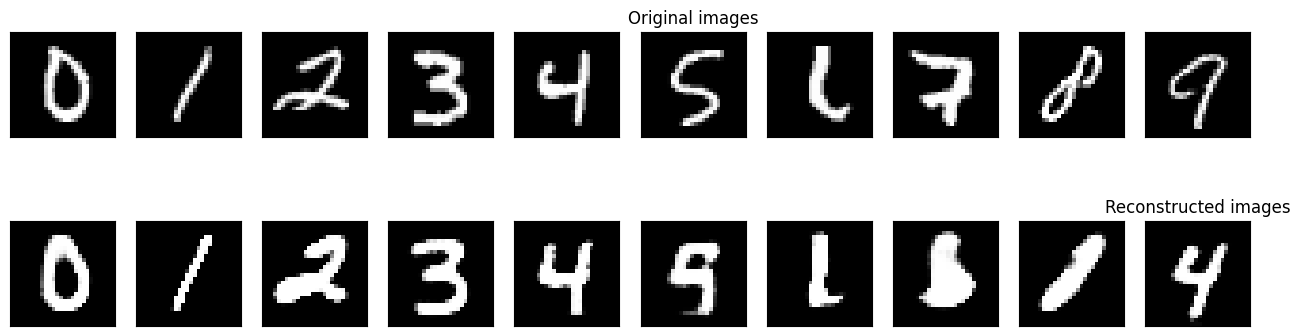

In [22]:
d = 4

epochs = 50
vae_model = VariationalAutoencoder(latent_dims=d).to(device)
optimal_VAE_model, _VAE_train_losses, VAE_val_losses, last_epoch = train_VAE(
    imbalanced_train_dataloader,
    imbalanced_val_dataloader,
    model=vae_model,
    epochs=epochs,
)

# Data Generator

In [23]:
def generate_data(data_set, cls):
    targets = data_set.targets
    sizee = len(np.where(targets == cls)[0])
    idx = np.where(targets == cls)[0][np.random.randint(sizee, size=1)[0]]
    img = data_set[idx][0].unsqueeze(0).to(device)
    vae.encoder.eval()
    vae.decoder.eval()
    with torch.no_grad():
        rec_img = vae.decoder(vae.encoder(img))
    rec_img = rec_img * 255
    orignal_image = img.squeeze().cpu()
    rec_img = rec_img.to(torch.int).squeeze(0).cpu()
    return rec_img, orignal_image

# Finding Dominant Class in Imbalanced Dataset

In [24]:
def find_dominant_class(imbalanced_train_dataset):
    class_distibution = Counter(imbalanced_train_dataset.targets.numpy())
    dominant_class_num = 0
    for i in class_distibution:
        if class_distibution[i] > dominant_class_num:
            dominant_class_num = class_distibution[i]

    return dominant_class_num, class_distibution

# Start Appending Data To Imbalanced Dataset

In [25]:
dominant_class_num, class_distibution = find_dominant_class(imbalanced_train_dataset)
aug_imbalanced_train_dataset = copy.deepcopy(imbalanced_train_dataset)
for i in class_distibution:
    print("======" * 10)
    print("\nCreating Data for Class: ", i)
    print("======" * 10)
    generate_samples = int(dominant_class_num - class_distibution[i])
    for j in range(generate_samples - 1):
        if j % 500 == 0:
            print(j, " Samples created...")
        synthetic_image, orignal_image = generate_data(imbalanced_train_dataset, i)
        pred = synthetic_image
        gt = orignal_image
        aug_imbalanced_train_dataset.targets = torch.tensor(
            np.append(aug_imbalanced_train_dataset.targets, [i], axis=0)
        )
        aug_imbalanced_train_dataset.data = torch.tensor(
            np.append(
                aug_imbalanced_train_dataset.data,
                synthetic_image.to(torch.uint8),
                axis=0,
            )
        )


imbalanced_train_dataset_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1302,), (0.3069,))]
)
aug_imbalanced_train_dataset.transform = imbalanced_train_dataset_transform


Creating Data for Class:  0

Creating Data for Class:  4
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...
4000  Samples created...
4500  Samples created...
5000  Samples created...

Creating Data for Class:  1
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...

Creating Data for Class:  3
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...
4000  Samples created...
4500  Samples created...

Creating Data for Class:  5
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...
4000  Samples created

# Bar Plot Synthetic Balanced Dataset

Distribution of classes in augmented Imbalanced dataset:
Counter({0: 5923, 4: 5922, 1: 5922, 3: 5922, 5: 5922, 2: 5922, 9: 5922, 8: 5922, 6: 5922, 7: 5922})


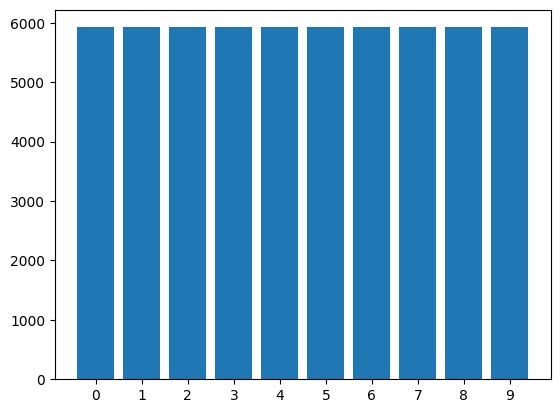

In [26]:
print("Distribution of classes in augmented Imbalanced dataset:")
print(Counter(aug_imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(aug_imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [27]:
m = len(aug_imbalanced_train_dataset)

aug_imbalanced_train_data, aug_imbalanced_val_data = random_split(
    aug_imbalanced_train_dataset,
    [int(m - m * 0.2), m - int(m - m * 0.2)],
    generator=torch.Generator().manual_seed(3),
)

aug_imbalanced_train_dataloader = torch.utils.data.DataLoader(
    aug_imbalanced_train_data, batch_size=128, shuffle=True
)
aug_imbalanced_val_dataloader = torch.utils.data.DataLoader(
    aug_imbalanced_val_data, batch_size=128, shuffle=True
)

# Train the above model like done earlier and print test data performance


In [28]:
epochs = 50
(
    aug_imb_optimal_model,
    aug_imb_train_losses,
    aug_imb_val_losses,
    aug_imb_val_accuracies,
    aug_imb_last_epoch,
) = train(
    aug_imbalanced_train_dataloader,
    aug_imbalanced_val_dataloader,
    ConvNet().to(device),
    epochs=epochs,
)

Epoch 1/50 train loss: 1.7778
Epoch 1/50 validation loss: 1.7155
Epoch 1/50 validation accuracy: 32.6805
Epoch 2/50 train loss: 1.6902
Epoch 2/50 validation loss: 1.6874
Epoch 2/50 validation accuracy: 32.5369
Epoch 3/50 train loss: 1.6750
Epoch 3/50 validation loss: 1.6830
Epoch 3/50 validation accuracy: 33.6851
Epoch 4/50 train loss: 1.6637
Epoch 4/50 validation loss: 1.6727
Epoch 4/50 validation accuracy: 33.5331
Epoch 5/50 train loss: 1.6580
Epoch 5/50 validation loss: 1.6644
Epoch 5/50 validation accuracy: 33.6935
Epoch 6/50 train loss: 1.6520
Epoch 6/50 validation loss: 1.6611
Epoch 6/50 validation accuracy: 33.5078
Epoch 7/50 train loss: 1.6483
Epoch 7/50 validation loss: 1.6606
Epoch 7/50 validation accuracy: 33.6176
Epoch 8/50 train loss: 1.6450
Epoch 8/50 validation loss: 1.6599
Epoch 8/50 validation accuracy: 33.7526
Epoch 9/50 train loss: 1.6427
Epoch 9/50 validation loss: 1.6552
Epoch 9/50 validation accuracy: 33.3558
Epoch 10/50 train loss: 1.6410
Epoch 10/50 validation l

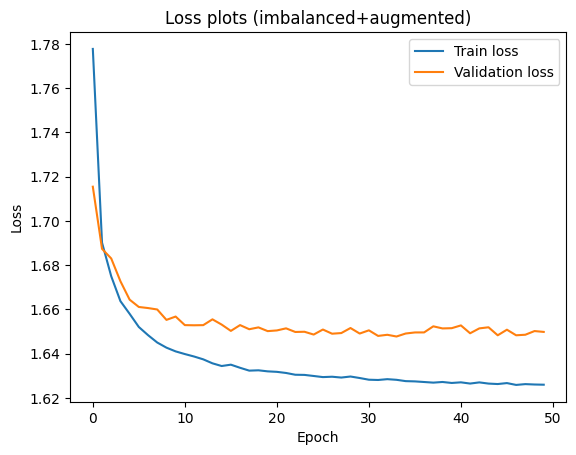

In [29]:
plt.plot(np.array(range(imb_last_epoch + 1)), aug_imb_train_losses, label="Train loss")
plt.plot(
    np.array(range(imb_last_epoch + 1)), aug_imb_val_losses, label="Validation loss"
)
plt.title("Loss plots (imbalanced+augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

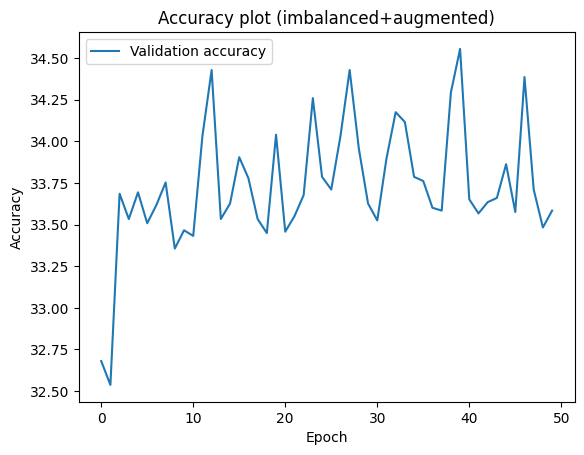

In [30]:
plt.plot(
    np.array(range(aug_imb_last_epoch + 1)),
    aug_imb_val_accuracies,
    label="Validation accuracy",
)
plt.title("Accuracy plot (imbalanced+augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [31]:
aug_imb_optimal_model_test_acc, percentages2 = test(aug_imb_optimal_model)
print("test accuracy : ", str(aug_imb_optimal_model_test_acc))


Test dataset: Overall Loss: 0.2451, Overall Accuracy: 9423/10000 (94%)

test accuracy :  94.23


# Comparison with baseline


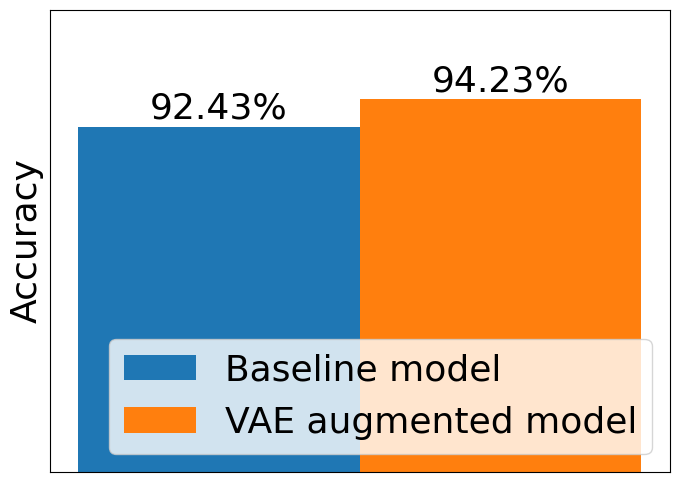

In [47]:
fig = plt.subplots(figsize=(8, 6))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(imb_optimal_model_test_acc).astype(float),
    width=0.1,
    label="Baseline model",
)
p2 = plt.bar(
    br2,
    np.array(aug_imb_optimal_model_test_acc).astype(float),
    width=0.1,
    label="VAE augmented model",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.legend(loc="lower right", fontsize=26)
plt.ylabel("Accuracy", fontsize=26)
plt.show()

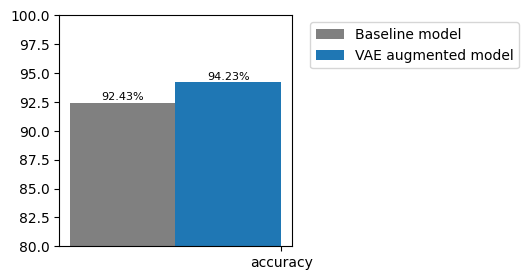

In [35]:
fig = plt.subplots(figsize=(3, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(imb_optimal_model_test_acc).astype(float),
    width=0.1,
    label="Baseline model",
    color="gray",
)
p2 = plt.bar(
    br2,
    np.array(aug_imb_optimal_model_test_acc).astype(float),
    width=0.1,
    label="VAE augmented model",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.xticks([r + 0.15 for r in range(1)], ["accuracy"])
plt.ylim(80, 100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

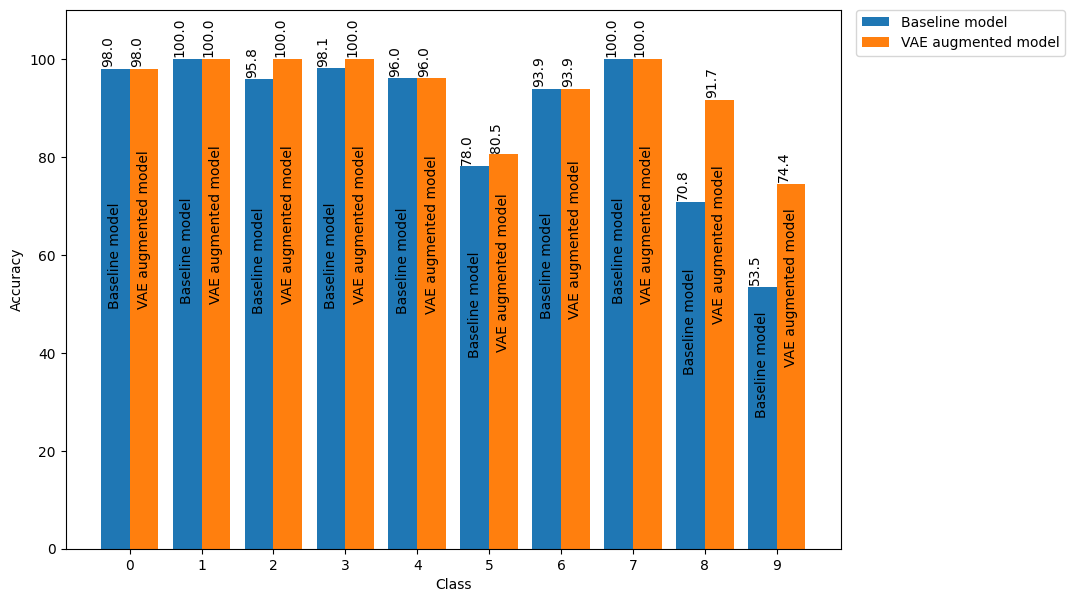

In [36]:
fig = plt.subplots(figsize=(10, 7))
br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
bar1 = plt.bar(
    br1, np.array(percentages1).astype(float) * 100.0, width=0.4, label="Baseline model"
)
bar2 = plt.bar(
    br2,
    np.array(percentages2).astype(float) * 100.0,
    width=0.4,
    label="VAE augmented model",
)
plt.xticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.ylim(0, 110)
for i, rect in enumerate(bar1 + bar2):
    height = rect.get_height() / 2
    if i > 9:
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height,
            "VAE augmented model",
            ha="center",
            va="bottom",
            rotation="vertical",
        )
    else:
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height,
            "Baseline model",
            ha="center",
            va="bottom",
            rotation="vertical",
        )

for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, "%.1f" % (yval), rotation="vertical")

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, "%.1f" % (yval), rotation="vertical")


plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.xlabel("Class")
plt.ylabel("Accuracy")

plt.show()

In [42]:
np.array(percentages1) * 100

array([ 98.        , 100.        ,  95.83333333,  98.07692308,
        96.        ,  78.04878049,  93.87755102, 100.        ,
        70.83333333,  53.48837209])

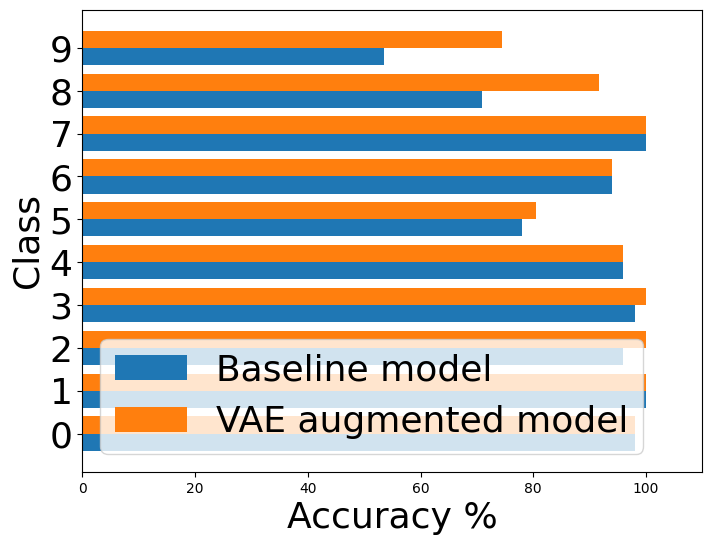

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]

p1 = plt.barh(
    br1, np.array(percentages1).astype(float) * 100, height=0.4, label="Baseline model"
)
p2 = plt.barh(
    br2,
    np.array(percentages2).astype(float) * 100,
    height=0.4,
    label="VAE augmented model",
)

plt.yticks(
    [r + 0.2 for r in range(10)],
    ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    fontsize=26,
)
plt.xlim(0, 110)
plt.legend(loc="lower left", fontsize=26)
plt.ylabel("Class", fontsize=26)
plt.xlabel("Accuracy %", fontsize=26)
plt.show()

In [46]:
df = pd.DataFrame(
    {"Baseline model": percentages1, "VAE augmented model": percentages2},
    index=range(10),
)
df

,Baseline model,VAE augmented model
0,0.980000,0.980000
1,1.000000,1.000000
2,0.958333,1.000000
3,0.980769,1.000000
4,0.960000,0.960000
5,0.780488,0.804878
6,0.938776,0.938776
7,1.000000,1.000000
8,0.708333,0.916667
9,0.534884,0.744186
